In [1]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

<h2> Tracking Experiments and registering model using Opensource libray Mlflow </h2>

In [2]:
import pickle

In [5]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("first-mlflow-experiement")

2022/05/29 11:51:37 INFO mlflow.tracking.fluent: Experiment with name 'first-mlflow-experiement' does not exist. Creating a new experiment.


<Experiment: artifact_location='./mlruns/1', experiment_id='1', lifecycle_stage='active', name='first-mlflow-experiement', tags={}>

In [37]:
data = pd.read_parquet('data/green_tripdata_2021-01.parquet')

In [7]:
data.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

In [38]:
data['duration'] = data['lpep_dropoff_datetime'] - data['lpep_pickup_datetime']
data.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,0 days 00:03:56
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,0 days 00:08:45
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,0 days 00:05:58
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,0 days 00:07:05
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,...,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00,0 days 00:00:04


In [39]:
data.duration = data.duration.apply(lambda td: td.total_seconds()/60)
data.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,...,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00,0.066667


In [40]:
data = data[(data.duration >= 1) & (data.duration <= 60)]

In [41]:
categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']

In [42]:
data[categorical] = data[categorical].astype('str')

In [43]:
train_dicts = data[categorical+numerical].to_dict(orient='records')

In [44]:
dv = DictVectorizer()
x_train = dv.fit_transform(train_dicts)
x_train

<73908x507 sparse matrix of type '<class 'numpy.float64'>'
	with 221724 stored elements in Compressed Sparse Row format>

In [45]:
y_train = data.duration.values
y_train

array([ 3.93333333,  8.75      ,  5.96666667, ..., 11.        ,
       27.        , 10.        ])

In [16]:
model = LinearRegression()
model.fit(x_train,y_train)
preds = model.predict(x_train)

C:\Users\jugal\.conda\envs\mlops-zoomcamp\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\jugal\.conda\envs\mlops-zoomcamp\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


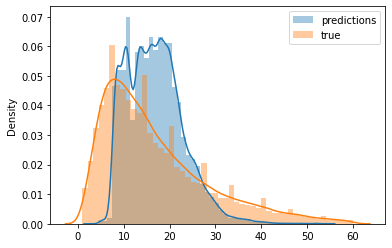

In [17]:
sns.distplot(preds,label='predictions')
sns.distplot(y_train,label='true')

plt.legend()


In [18]:
mean_squared_error(y_train,preds,squared=False)

9.827368941909368

In [19]:
def read_dataframe(file_name):
    
    if file_name.endswith('.csv'):
        data = pd.read_csv('data/'+file_name)
        
    else:
        data = pd.read_parquet('data/'+file_name)
        
    
    data['duration'] = data.lpep_dropoff_datetime - data.lpep_pickup_datetime
        
    data.duration = data.duration.apply(lambda dt: dt.total_seconds()/60)
        
    categorical = ['PULocationID','DOLocationID']
    numerical = ['trip_distance']
    
    data = data[(data.duration >= 1) & (data.duration <= 60)]
    
    data[categorical] = data[categorical].astype(str)

    return data

    

In [46]:
train_data = read_dataframe('green_tripdata_2021-01.parquet')
val_data = read_dataframe('green_tripdata_2021-02.parquet')

In [47]:
train_data.shape,val_data.shape

((73908, 21), (61921, 21))

In [48]:
train_data['PUDO'] = train_data['PULocationID'] + '_' + train_data['DOLocationID']
val_data['PUDO'] = val_data['PULocationID'] + '_' + val_data['DOLocationID']


In [49]:
categorical = ['PUDO']
numerical = ['trip_distance']

data_dicts = train_data[categorical+numerical].to_dict(orient='Records')


In [50]:
x_train = dv.fit_transform(train_dicts)
val_dicts = val_data[categorical+numerical].to_dict(orient='records')
x_val = dv.transform(val_dicts)

In [51]:
y_train = train_data.duration.values
y_val = val_data.duration.values

In [52]:
y_train,y_val

(array([ 3.93333333,  8.75      ,  5.96666667, ..., 11.        ,
        27.        , 10.        ]),
 array([17.91666667,  6.5       , 15.25      , ..., 14.        ,
         7.        ,  7.        ]))

In [27]:
lr = LinearRegression()
lr.fit(x_train,y_train)

y_pred = lr.predict(x_val)

mean_squared_error(y_val,y_pred,squared=False)

12.948606599931619

In [28]:
with open('models/lin_reg.bin','wb') as f:
    pickle.dump((dv,lr),f)


In [29]:
with mlflow.start_run():
    
    mlflow.set_tag("model","Lasso Regression")
    mlflow.log_param("train-data-path",".\data\green_tripdata_2021-01.parquet")
    mlflow.log_param("val-data-path",".\data\green_tripdata_2021-02.parquet")
    
    alpha = 0.1
    
    mlflow.log_param("Alpha",alpha)
    
    lasso = Lasso(alpha)
    lasso.fit(x_train,y_train)

    y_pred = lasso.predict(x_val)

    metrics = mean_squared_error(y_val,y_pred,squared=False)
    
    mlflow.log_metric("RMSE",metrics)
    


In [30]:
import xgboost as xgb

from hyperopt import fmin,tpe,hp,STATUS_OK,Trials
from hyperopt.pyll import scope

In [31]:
train = xgb.DMatrix(x_train,label=y_train)
valid = xgb.DMatrix(x_val,label=y_val)

In [32]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model","xgboost")
        mlflow.log_params(params)
        
        booster = xgb.train(params=params,dtrain=train,num_boost_round=1000,evals=[(valid,"validation")],early_stopping_rounds=50)
        
        y_pred = booster.predict(valid)
        
        rmse = mean_squared_error(y_val,y_pred,squared=False)
        
        mlflow.log_metric("RMSE",rmse)
        
    return {"loss":rmse,"status": STATUS_OK}


In [33]:
search_space = {
    'max_depth' : scope.int(hp.quniform('max_depth',4,100,1)),
    'learning_rate' : hp.loguniform('learning_rate',-3,0),
    'reg_alpha' : hp.loguniform('reg_alpha',-5,-1),
    'reg_lambda' : hp.loguniform('reg_lambda',-6,-1),
    'min_child_weight' : hp.loguniform('min_child_weight',-1,3),
    'objective' : 'reg:linear',
    'seed' : 42
}

best_result = fmin(fn=objective,
                  space=search_space,
                  algo = tpe.suggest,
                  max_evals=20,
                  trials=Trials())

[11:55:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:15.53553                                                                                           
[1]	validation-rmse:12.00332                                                                                           
[2]	validation-rmse:9.88641                                                                                            
[3]	validation-rmse:8.66301                                                                                            
[4]	validation-rmse:7.94836                                                                                            
[5]	validation-rmse:7.55096                                                                                            
[6]	validation-rmse:7.31380                                                                            

[66]	validation-rmse:6.95527                                                                                           
[67]	validation-rmse:6.95521                                                                                           
[68]	validation-rmse:6.95497                                                                                           
[69]	validation-rmse:6.95633                                                                                           
[70]	validation-rmse:6.95627                                                                                           
[71]	validation-rmse:6.95818                                                                                           
[72]	validation-rmse:6.95786                                                                                           
[73]	validation-rmse:6.95799                                                                                           
[74]	validation-rmse:6.95836            

[56]	validation-rmse:6.90658                                                                                           
[57]	validation-rmse:6.89910                                                                                           
[58]	validation-rmse:6.89624                                                                                           
[59]	validation-rmse:6.89179                                                                                           
[60]	validation-rmse:6.88957                                                                                           
[61]	validation-rmse:6.88498                                                                                           
[62]	validation-rmse:6.87962                                                                                           
[63]	validation-rmse:6.87795                                                                                           
[64]	validation-rmse:6.87666            

[124]	validation-rmse:6.86121                                                                                          
[125]	validation-rmse:6.86089                                                                                          
[126]	validation-rmse:6.86161                                                                                          
[127]	validation-rmse:6.86044                                                                                          
[128]	validation-rmse:6.86020                                                                                          
[129]	validation-rmse:6.86093                                                                                          
[130]	validation-rmse:6.86112                                                                                          
[131]	validation-rmse:6.86175                                                                                          
[132]	validation-rmse:6.86124           

[46]	validation-rmse:6.89213                                                                                           
[47]	validation-rmse:6.89056                                                                                           
[48]	validation-rmse:6.89069                                                                                           
[49]	validation-rmse:6.89034                                                                                           
[50]	validation-rmse:6.88936                                                                                           
[51]	validation-rmse:6.89018                                                                                           
[52]	validation-rmse:6.88982                                                                                           
[53]	validation-rmse:6.88935                                                                                           
[54]	validation-rmse:6.88752            

[114]	validation-rmse:6.88203                                                                                          
[115]	validation-rmse:6.88199                                                                                          
[116]	validation-rmse:6.88218                                                                                          
[117]	validation-rmse:6.88203                                                                                          
[118]	validation-rmse:6.88214                                                                                          
[119]	validation-rmse:6.88207                                                                                          
[120]	validation-rmse:6.88188                                                                                          
[121]	validation-rmse:6.88156                                                                                          
[122]	validation-rmse:6.88155           

[0]	validation-rmse:16.61502                                                                                           
[1]	validation-rmse:13.40789                                                                                           
[2]	validation-rmse:11.21951                                                                                           
[3]	validation-rmse:9.75507                                                                                            
[4]	validation-rmse:8.75695                                                                                            
[5]	validation-rmse:8.10115                                                                                            
[6]	validation-rmse:7.69000                                                                                            
[7]	validation-rmse:7.42053                                                                                            
[8]	validation-rmse:7.24339             

[68]	validation-rmse:6.87834                                                                                           
[69]	validation-rmse:6.87832                                                                                           
[70]	validation-rmse:6.87828                                                                                           
[71]	validation-rmse:6.87873                                                                                           
[72]	validation-rmse:6.87874                                                                                           
[73]	validation-rmse:6.87892                                                                                           
[74]	validation-rmse:6.87906                                                                                           
[75]	validation-rmse:6.87920                                                                                           
[76]	validation-rmse:6.87938            

[57]	validation-rmse:6.99938                                                                                           
[58]	validation-rmse:6.99899                                                                                           
[59]	validation-rmse:6.99832                                                                                           
[60]	validation-rmse:6.99806                                                                                           
[61]	validation-rmse:6.99751                                                                                           
[62]	validation-rmse:6.99685                                                                                           
[63]	validation-rmse:6.99649                                                                                           
[64]	validation-rmse:6.99645                                                                                           
[65]	validation-rmse:6.99677            

[125]	validation-rmse:7.00313                                                                                          
[126]	validation-rmse:7.00326                                                                                          
[127]	validation-rmse:7.00348                                                                                          
[128]	validation-rmse:7.00336                                                                                          
[129]	validation-rmse:7.00360                                                                                          
[130]	validation-rmse:7.00363                                                                                          
[131]	validation-rmse:7.00346                                                                                          
[132]	validation-rmse:7.00361                                                                                          
[133]	validation-rmse:7.00396           

[49]	validation-rmse:7.02516                                                                                           
[50]	validation-rmse:7.02607                                                                                           
[51]	validation-rmse:7.02640                                                                                           
[52]	validation-rmse:7.02651                                                                                           
[53]	validation-rmse:7.02719                                                                                           
[54]	validation-rmse:7.02728                                                                                           
[55]	validation-rmse:7.02781                                                                                           
[56]	validation-rmse:7.03124                                                                                           
[11:58:03] WARNING: C:/Users/Administrat

[0]	validation-rmse:10.64107                                                                                           
[1]	validation-rmse:7.80533                                                                                            
[2]	validation-rmse:7.13344                                                                                            
[3]	validation-rmse:6.97912                                                                                            
[4]	validation-rmse:6.93108                                                                                            
[5]	validation-rmse:6.90904                                                                                            
[6]	validation-rmse:6.90738                                                                                            
[7]	validation-rmse:6.90523                                                                                            
[8]	validation-rmse:6.90719             

[8]	validation-rmse:13.03238                                                                                           
[9]	validation-rmse:12.46508                                                                                           
[10]	validation-rmse:11.95028                                                                                          
[11]	validation-rmse:11.48616                                                                                          
[12]	validation-rmse:11.05868                                                                                          
[13]	validation-rmse:10.67407                                                                                          
[14]	validation-rmse:10.32598                                                                                          
[15]	validation-rmse:10.01157                                                                                          
[16]	validation-rmse:9.72586            

[76]	validation-rmse:7.06240                                                                                           
[77]	validation-rmse:7.06162                                                                                           
[78]	validation-rmse:7.06056                                                                                           
[79]	validation-rmse:7.05934                                                                                           
[80]	validation-rmse:7.05833                                                                                           
[81]	validation-rmse:7.05758                                                                                           
[82]	validation-rmse:7.05730                                                                                           
[83]	validation-rmse:7.05607                                                                                           
[84]	validation-rmse:7.05523            

[144]	validation-rmse:7.05044                                                                                          
[145]	validation-rmse:7.05034                                                                                          
[146]	validation-rmse:7.05019                                                                                          
[147]	validation-rmse:7.05002                                                                                          
[148]	validation-rmse:7.05001                                                                                          
[149]	validation-rmse:7.05006                                                                                          
[150]	validation-rmse:7.05011                                                                                          
[151]	validation-rmse:7.04996                                                                                          
[152]	validation-rmse:7.05006           

[57]	validation-rmse:6.98458                                                                                           
[58]	validation-rmse:6.98366                                                                                           
[59]	validation-rmse:6.98248                                                                                           
[60]	validation-rmse:6.98137                                                                                           
[61]	validation-rmse:6.98046                                                                                           
[62]	validation-rmse:6.98009                                                                                           
[63]	validation-rmse:6.97950                                                                                           
[64]	validation-rmse:6.97902                                                                                           
[65]	validation-rmse:6.97920            

[125]	validation-rmse:6.98449                                                                                          
[126]	validation-rmse:6.98449                                                                                          
[127]	validation-rmse:6.98462                                                                                          
[128]	validation-rmse:6.98458                                                                                          
[129]	validation-rmse:6.98549                                                                                          
[130]	validation-rmse:6.98602                                                                                          
[131]	validation-rmse:6.98673                                                                                          
[132]	validation-rmse:6.98680                                                                                          
[133]	validation-rmse:6.98697           

[56]	validation-rmse:6.91292                                                                                           
[57]	validation-rmse:6.90921                                                                                           
[58]	validation-rmse:6.90664                                                                                           
[59]	validation-rmse:6.90404                                                                                           
[60]	validation-rmse:6.90187                                                                                           
[61]	validation-rmse:6.90042                                                                                           
[62]	validation-rmse:6.89898                                                                                           
[63]	validation-rmse:6.89769                                                                                           
[64]	validation-rmse:6.89776            

[124]	validation-rmse:6.87885                                                                                          
[125]	validation-rmse:6.87859                                                                                          
[126]	validation-rmse:6.87852                                                                                          
[127]	validation-rmse:6.87881                                                                                          
[128]	validation-rmse:6.87884                                                                                          
[129]	validation-rmse:6.87879                                                                                          
[130]	validation-rmse:6.87895                                                                                          
[131]	validation-rmse:6.87879                                                                                          
[132]	validation-rmse:6.87839           

[192]	validation-rmse:6.87776                                                                                          
[193]	validation-rmse:6.87762                                                                                          
[194]	validation-rmse:6.87752                                                                                          
[195]	validation-rmse:6.87749                                                                                          
[196]	validation-rmse:6.87746                                                                                          
[197]	validation-rmse:6.87735                                                                                          
[198]	validation-rmse:6.87730                                                                                          
[199]	validation-rmse:6.87725                                                                                          
[200]	validation-rmse:6.87735           

[9]	validation-rmse:6.96192                                                                                            
[10]	validation-rmse:6.93442                                                                                           
[11]	validation-rmse:6.92050                                                                                           
[12]	validation-rmse:6.91586                                                                                           
[13]	validation-rmse:6.90210                                                                                           
[14]	validation-rmse:6.89232                                                                                           
[15]	validation-rmse:6.88917                                                                                           
[16]	validation-rmse:6.89484                                                                                           
[17]	validation-rmse:6.89271            

[77]	validation-rmse:6.88952                                                                                           
[78]	validation-rmse:6.89001                                                                                           
[12:01:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:19.48808                                                                                           
[1]	validation-rmse:17.97451                                                                                           
[2]	validation-rmse:16.62526                                                                                           
[3]	validation-rmse:15.43854                                                                                           
[4]	validation-rmse:14.38220                                                                           

[64]	validation-rmse:6.95948                                                                                           
[65]	validation-rmse:6.95869                                                                                           
[66]	validation-rmse:6.95842                                                                                           
[67]	validation-rmse:6.95850                                                                                           
[68]	validation-rmse:6.95819                                                                                           
[69]	validation-rmse:6.95769                                                                                           
[70]	validation-rmse:6.95748                                                                                           
[71]	validation-rmse:6.95716                                                                                           
[72]	validation-rmse:6.95661            

[132]	validation-rmse:6.95790                                                                                          
[133]	validation-rmse:6.95838                                                                                          
[134]	validation-rmse:6.95868                                                                                          
[135]	validation-rmse:6.95871                                                                                          
[136]	validation-rmse:6.95931                                                                                          
[137]	validation-rmse:6.95962                                                                                          
[138]	validation-rmse:6.95944                                                                                          
[139]	validation-rmse:6.95917                                                                                          
[140]	validation-rmse:6.95915           

[38]	validation-rmse:6.87855                                                                                           
[39]	validation-rmse:6.88022                                                                                           
[40]	validation-rmse:6.87869                                                                                           
[41]	validation-rmse:6.87971                                                                                           
[42]	validation-rmse:6.88100                                                                                           
[43]	validation-rmse:6.88057                                                                                           
[44]	validation-rmse:6.87892                                                                                           
[45]	validation-rmse:6.87889                                                                                           
[46]	validation-rmse:6.88119            

[21]	validation-rmse:6.82088                                                                                           
[22]	validation-rmse:6.82129                                                                                           
[23]	validation-rmse:6.82194                                                                                           
[24]	validation-rmse:6.82218                                                                                           
[25]	validation-rmse:6.82240                                                                                           
[26]	validation-rmse:6.82249                                                                                           
[27]	validation-rmse:6.82273                                                                                           
[28]	validation-rmse:6.82274                                                                                           
[29]	validation-rmse:6.82278            

[22]	validation-rmse:8.27428                                                                                           
[23]	validation-rmse:8.12507                                                                                           
[24]	validation-rmse:8.00324                                                                                           
[25]	validation-rmse:7.89087                                                                                           
[26]	validation-rmse:7.79321                                                                                           
[27]	validation-rmse:7.70066                                                                                           
[28]	validation-rmse:7.61162                                                                                           
[29]	validation-rmse:7.53618                                                                                           
[30]	validation-rmse:7.47424            

[90]	validation-rmse:6.83390                                                                                           
[91]	validation-rmse:6.83349                                                                                           
[92]	validation-rmse:6.83312                                                                                           
[93]	validation-rmse:6.83304                                                                                           
[94]	validation-rmse:6.83276                                                                                           
[95]	validation-rmse:6.83246                                                                                           
[96]	validation-rmse:6.83237                                                                                           
[97]	validation-rmse:6.83242                                                                                           
[98]	validation-rmse:6.83240            

[0]	validation-rmse:17.75161                                                                                           
[1]	validation-rmse:15.10420                                                                                           
[2]	validation-rmse:13.07233                                                                                           
[3]	validation-rmse:11.54351                                                                                           
[4]	validation-rmse:10.39279                                                                                           
[5]	validation-rmse:9.53621                                                                                            
[6]	validation-rmse:8.90175                                                                                            
[7]	validation-rmse:8.46282                                                                                            
[8]	validation-rmse:8.13748             

[68]	validation-rmse:7.16536                                                                                           
[69]	validation-rmse:7.16550                                                                                           
[70]	validation-rmse:7.16510                                                                                           
[71]	validation-rmse:7.16538                                                                                           
[72]	validation-rmse:7.16629                                                                                           
[73]	validation-rmse:7.16653                                                                                           
[74]	validation-rmse:7.16679                                                                                           
[75]	validation-rmse:7.16633                                                                                           
[76]	validation-rmse:7.16668            

[49]	validation-rmse:6.89849                                                                                           
[50]	validation-rmse:6.89666                                                                                           
[51]	validation-rmse:6.89639                                                                                           
[52]	validation-rmse:6.89312                                                                                           
[53]	validation-rmse:6.89232                                                                                           
[54]	validation-rmse:6.88946                                                                                           
[55]	validation-rmse:6.88690                                                                                           
[56]	validation-rmse:6.88275                                                                                           
[57]	validation-rmse:6.88143            

[117]	validation-rmse:6.87486                                                                                          
[118]	validation-rmse:6.87499                                                                                          
[119]	validation-rmse:6.87488                                                                                          
[120]	validation-rmse:6.87478                                                                                          
[121]	validation-rmse:6.87543                                                                                          
[122]	validation-rmse:6.87532                                                                                          
[123]	validation-rmse:6.87462                                                                                          
[124]	validation-rmse:6.87504                                                                                          
[125]	validation-rmse:6.87579           

[185]	validation-rmse:6.87142                                                                                          
[186]	validation-rmse:6.87154                                                                                          
[187]	validation-rmse:6.87156                                                                                          
[188]	validation-rmse:6.87118                                                                                          
[189]	validation-rmse:6.87171                                                                                          
[190]	validation-rmse:6.87138                                                                                          
[191]	validation-rmse:6.87133                                                                                          
[192]	validation-rmse:6.87141                                                                                          
[193]	validation-rmse:6.87119           

[253]	validation-rmse:6.86753                                                                                          
[254]	validation-rmse:6.86737                                                                                          
[255]	validation-rmse:6.86719                                                                                          
[256]	validation-rmse:6.86716                                                                                          
[257]	validation-rmse:6.86722                                                                                          
[258]	validation-rmse:6.86741                                                                                          
[259]	validation-rmse:6.86752                                                                                          
[260]	validation-rmse:6.86707                                                                                          
[261]	validation-rmse:6.86679           

[321]	validation-rmse:6.86629                                                                                          
[322]	validation-rmse:6.86620                                                                                          
[323]	validation-rmse:6.86607                                                                                          
[324]	validation-rmse:6.86599                                                                                          
[325]	validation-rmse:6.86601                                                                                          
[326]	validation-rmse:6.86608                                                                                          
[327]	validation-rmse:6.86602                                                                                          
[328]	validation-rmse:6.86585                                                                                          
[329]	validation-rmse:6.86597           

[389]	validation-rmse:6.86342                                                                                          
[390]	validation-rmse:6.86337                                                                                          
[391]	validation-rmse:6.86336                                                                                          
[392]	validation-rmse:6.86343                                                                                          
[393]	validation-rmse:6.86332                                                                                          
[394]	validation-rmse:6.86326                                                                                          
[395]	validation-rmse:6.86329                                                                                          
[396]	validation-rmse:6.86334                                                                                          
[397]	validation-rmse:6.86333           

[457]	validation-rmse:6.86141                                                                                          
[458]	validation-rmse:6.86151                                                                                          
[459]	validation-rmse:6.86141                                                                                          
[460]	validation-rmse:6.86141                                                                                          
[461]	validation-rmse:6.86152                                                                                          
[462]	validation-rmse:6.86143                                                                                          
[463]	validation-rmse:6.86154                                                                                          
[464]	validation-rmse:6.86143                                                                                          
[465]	validation-rmse:6.86137           

[525]	validation-rmse:6.85871                                                                                          
[526]	validation-rmse:6.85875                                                                                          
[527]	validation-rmse:6.85877                                                                                          
[528]	validation-rmse:6.85877                                                                                          
[529]	validation-rmse:6.85892                                                                                          
[530]	validation-rmse:6.85895                                                                                          
[531]	validation-rmse:6.85892                                                                                          
[532]	validation-rmse:6.85902                                                                                          
[533]	validation-rmse:6.85894           

[593]	validation-rmse:6.85840                                                                                          
[594]	validation-rmse:6.85829                                                                                          
[595]	validation-rmse:6.85835                                                                                          
[596]	validation-rmse:6.85835                                                                                          
[597]	validation-rmse:6.85846                                                                                          
[598]	validation-rmse:6.85851                                                                                          
[599]	validation-rmse:6.85849                                                                                          
[600]	validation-rmse:6.85871                                                                                          
[601]	validation-rmse:6.85867           

[29]	validation-rmse:6.91073                                                                                           
[30]	validation-rmse:6.90708                                                                                           
[31]	validation-rmse:6.90125                                                                                           
[32]	validation-rmse:6.89833                                                                                           
[33]	validation-rmse:6.89495                                                                                           
[34]	validation-rmse:6.89131                                                                                           
[35]	validation-rmse:6.88780                                                                                           
[36]	validation-rmse:6.88314                                                                                           
[37]	validation-rmse:6.88310            

[97]	validation-rmse:6.87082                                                                                           
[98]	validation-rmse:6.87093                                                                                           
[99]	validation-rmse:6.87046                                                                                           
[100]	validation-rmse:6.87055                                                                                          
[101]	validation-rmse:6.87039                                                                                          
[102]	validation-rmse:6.87048                                                                                          
[103]	validation-rmse:6.87043                                                                                          
[104]	validation-rmse:6.87142                                                                                          
[105]	validation-rmse:6.87122           

[165]	validation-rmse:6.86722                                                                                          
[166]	validation-rmse:6.86706                                                                                          
[167]	validation-rmse:6.86725                                                                                          
[168]	validation-rmse:6.86739                                                                                          
[169]	validation-rmse:6.86756                                                                                          
[170]	validation-rmse:6.86751                                                                                          
[171]	validation-rmse:6.86727                                                                                          
[172]	validation-rmse:6.86703                                                                                          
[173]	validation-rmse:6.86700           

[233]	validation-rmse:6.86675                                                                                          
[234]	validation-rmse:6.86666                                                                                          
[235]	validation-rmse:6.86673                                                                                          
[12:06:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:13.58002                                                                                           
[1]	validation-rmse:9.84499                                                                                            
[2]	validation-rmse:8.18395                                                                                            
[3]	validation-rmse:7.46896                                                                            

[63]	validation-rmse:6.87494                                                                                           
[64]	validation-rmse:6.87491                                                                                           
[65]	validation-rmse:6.87519                                                                                           
[66]	validation-rmse:6.87640                                                                                           
[67]	validation-rmse:6.87649                                                                                           
[68]	validation-rmse:6.87692                                                                                           
[69]	validation-rmse:6.87773                                                                                           
[70]	validation-rmse:6.87880                                                                                           
[71]	validation-rmse:6.87864            

In [35]:

params = {
    'learning_rate':0.38224953779852067,
    'max_depth':94,
    'min_child_weight':0.8380472896224769,
    'objective': 'reg:linear',
    'reg_alpha':0.08594677002588899,
    'reg_lambda':0.17515937955354294,

}

mlflow.xgboost.autolog()

booster = xgb.train(params=params,dtrain=train,num_boost_round=1000,evals=[(valid,"validation")],early_stopping_rounds=50)

2022/05/29 15:38:18 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '9f8c0c3dd54b48ea86dc8b917164cb91', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[15:38:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:14.45718
[1]	validation-rmse:10.72407
[2]	validation-rmse:8.74360
[3]	validation-rmse:7.82377
[4]	validation-rmse:7.33586
[5]	validation-rmse:7.08631
[6]	validation-rmse:6.96071
[7]	validation-rmse:6.90056
[8]	validation-rmse:6.85857
[9]	validation-rmse:6.84177
[10]	validation-rmse:6.83255
[11]	validation-rmse:6.82441
[12]	validation-rmse:6.82155
[13]	validation-rmse:6.81990
[14]	validation-rmse:6.81939
[15]	validation-rmse:6.81863
[16]	validation-rmse:6.81964
[17]	validation-rmse:6.81984
[18]	validation-rmse:6.82097
[19]	validation-rmse:6.82059
[20]	validation-rmse:6.82056
[21]	validation-rmse:6.82088
[22]	validation-rmse:6.82129
[23]	validation-rmse:6.82194
[24]	validation-rmse:6.82218
[25]	validation-rmse:6.82240
[26]	validation-rmse:6.82249
[27]	validation-rmse:6.82273
[28]	validation-rms

2022/05/29 15:38:56 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2022/05/29 15:39:11 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "C:\Users\jugal\.conda\envs\mlops-zoomcamp\lib\site-packages\_distutils_hack\__init__.py:30: UserWarning: Setuptools is replacing distutils."


In [55]:
mlflow.xgboost.autolog(disable=True)

In [56]:
with mlflow.start_run():
    
    train = xgb.DMatrix(x_train,label=y_train)
    valid = xgb.DMatrix(x_val,label=y_val)
    
    mlflow.log_params(params)
    
    with open('preprocessor.b','wb') as f:
        pickle.dump(dv,f)
        
    mlflow.log_artifact('preprocessor.b','Preprocessors')
    
    booster = xgb.train(params,dtrain=train,num_boost_round=1000,evals=[(valid,'validation')],early_stopping_rounds=50)
    
    y_pred = booster.predict(valid)
    
    rmse = mean_squared_error(y_val,y_pred,squared=False)
    
    mlflow.log_metric("RMSE",rmse)
    
    mlflow.xgboost.log_model(booster,artifact_path="models_mlflow")

[16:05:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:14.45718
[1]	validation-rmse:10.72407
[2]	validation-rmse:8.74360
[3]	validation-rmse:7.82377
[4]	validation-rmse:7.33586
[5]	validation-rmse:7.08631
[6]	validation-rmse:6.96071
[7]	validation-rmse:6.90056
[8]	validation-rmse:6.85857
[9]	validation-rmse:6.84177
[10]	validation-rmse:6.83255
[11]	validation-rmse:6.82441
[12]	validation-rmse:6.82155
[13]	validation-rmse:6.81990
[14]	validation-rmse:6.81939
[15]	validation-rmse:6.81863
[16]	validation-rmse:6.81964
[17]	validation-rmse:6.81984
[18]	validation-rmse:6.82097
[19]	validation-rmse:6.82059
[20]	validation-rmse:6.82056
[21]	validation-rmse:6.82088
[22]	validation-rmse:6.82129
[23]	validation-rmse:6.82194
[24]	validation-rmse:6.82218
[25]	validation-rmse:6.82240
[26]	validation-rmse:6.82249
[27]	validation-rmse:6.82273
[28]	validation-rms

In [57]:
logged_model = 'runs:/a21214114c204c569838eb19b17ad41f/models_mlflow'

loaded_model = mlflow.pyfunc.load_model(logged_model)



[16:09:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [58]:
model = mlflow.xgboost.load_model(logged_model)

model

[16:10:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


In [59]:
predictions = model.predict(valid)
predictions

array([18.926628 ,  7.970323 , 21.285213 , ..., 14.006999 ,  7.8343873,
        9.146785 ], dtype=float32)